# HMMs and Viterbi algorithm for POS tagging

<b>Submitted by Barkha Saxena</b>

---
<span size=8 style=" font-family: Arial; font-size: 1.9em;"> Table of Contents</span>

---

1. Objective
2. Data Preparation
3. Vanilla Viterbi
4. Observing Unknown Words
5. Viterbi Modification-Technique I
6. Viterbi Modification-Technique II
7. Comparing the tagging accuracies 
8. Corrections by Modification

## 1. Objective:

Modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques using
12 coarse tag classes from tagset of NLTK. The data is divided with a sample size of 95:5 for training: validation sets.

<b>Technique 1:</b> for unknown words the emission probability becomes zero so while calculating the maximum probability in Viterbi use only transition probability for unknown words. Also, take into account the probability of occurence of POS Tags according to the training data.

<b>Technique 2:</b> Using ngram tagger backed off by rule based (generalized rules), evaluating the unigram, bigram, trigram taggers backed off by rules to identify POS Tags for Unknown words

## 2. Data Preparation

In [1]:
#Importing libraries
import nltk
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# checking data
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

<b>Note:</b>

    The nltk data loaded comprises of a list of sentences comprising of a list of words tagged with the appropriate POS tag.Tokenization is already been taken care of.

<b>Checking the total number of POS Tags present in the tagged data</b>

In [4]:
POS_tags = {tag[1] for sent in nltk_data for tag in sent}
print("Total number of POS Tags in data: ",len(POS_tags))
print("POS Tags:",POS_tags)

Total number of POS Tags in data:  12
POS Tags: {'.', 'CONJ', 'ADJ', 'VERB', 'PRON', 'ADV', 'ADP', 'PRT', 'DET', 'NUM', 'NOUN', 'X'}


### 2.1 Split data into training and validation set 

In [5]:
#Split data into training and validation set in the ratio 95:5
random.seed(1234)
train_data, validation_data = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

In [6]:
print("Sentences in Training Data:", len(train_data))
print("Sentences in Validation Data:", len(validation_data))

Sentences in Training Data: 3718
Sentences in Validation Data: 196


#### Training Data

In [7]:
#observing training data
print("Training Data:\n")
print(train_data[:2])

Training Data:

[[('Western', 'NOUN'), ('Gas', 'NOUN'), ('Resources', 'NOUN'), ('Inc.', 'NOUN'), (',', '.'), ('initial', 'ADJ'), ('offering', 'NOUN'), ('of', 'ADP'), ('3,250,000', 'NUM'), ('shares', 'NOUN'), ('of', 'ADP'), ('common', 'ADJ'), ('stock', 'NOUN'), (',', '.'), ('of', 'ADP'), ('which', 'DET'), ('3,040,000', 'NUM'), ('shares', 'NOUN'), ('*T*-2', 'X'), ('will', 'VERB'), ('be', 'VERB'), ('sold', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ('and', 'CONJ'), ('210,000', 'NUM'), ('shares', 'NOUN'), ('*T*-2', 'X'), ('by', 'ADP'), ('a', 'DET'), ('holder', 'NOUN'), (',', '.'), ('via', 'ADP'), ('Prudential-Bache', 'NOUN'), ('Capital', 'NOUN'), ('Funding', 'NOUN'), (',', '.'), ('Smith', 'NOUN'), ('Barney', 'NOUN'), (',', '.'), ('Harris', 'NOUN'), ('Upham', 'NOUN'), ('&', 'CONJ'), ('Co.', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('Hanifen', 'NOUN'), (',', '.'), ('Imhoff', 'NOUN'), ('Inc', 'NOUN'), ('.', '.')], [('Georgia-Pacific', 'NOUN'), ("'s", 'PRT'), ('sal

In [8]:
# Sentences to words 
train_tagged_words = [tup for sent in train_data for tup in sent]
print("Number of Tagged words in training data: ", len(train_tagged_words))
print("\nTraining words:")
print(train_tagged_words[:30])

Number of Tagged words in training data:  95467

Training words:
[('Western', 'NOUN'), ('Gas', 'NOUN'), ('Resources', 'NOUN'), ('Inc.', 'NOUN'), (',', '.'), ('initial', 'ADJ'), ('offering', 'NOUN'), ('of', 'ADP'), ('3,250,000', 'NUM'), ('shares', 'NOUN'), ('of', 'ADP'), ('common', 'ADJ'), ('stock', 'NOUN'), (',', '.'), ('of', 'ADP'), ('which', 'DET'), ('3,040,000', 'NUM'), ('shares', 'NOUN'), ('*T*-2', 'X'), ('will', 'VERB'), ('be', 'VERB'), ('sold', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ('and', 'CONJ'), ('210,000', 'NUM'), ('shares', 'NOUN'), ('*T*-2', 'X')]


<b>Note:</b>
    
    Notice now all words from all sentences are combined to a single list. 
    For example the 31st word 'She' which was in a different item in the previous list now is present in the same list.

In [9]:
# tokens in the train set - train_tagged_words
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['Western',
 'Gas',
 'Resources',
 'Inc.',
 ',',
 'initial',
 'offering',
 'of',
 '3,250,000',
 'shares']

In [10]:
# POS tags for the tokens in the train set - train_tagged_words

train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:10]

['NOUN', 'NOUN', 'NOUN', 'NOUN', '.', 'ADJ', 'NOUN', 'ADP', 'NUM', 'NOUN']

In [11]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)

In [12]:
# building the POS tags to a set
training_pos_tag_set = set(train_tagged_pos_tokens)
# let's check how many unique tags are present in training data
print("Total POS Tags in training data:",len(training_pos_tag_set))

Total POS Tags in training data: 12


In [13]:
print("Our training data vocabulary comprises of",len(training_vocabulary_set),"words")

Our training data vocabulary comprises of 12053 words


<b> Validation Data </b>

In [14]:
validation_tagged_words = [tup[0] for sent in validation_data for tup in sent]
print("Number of Tagged words in validation data: ", len(validation_tagged_words))
print("\n Validation data:")
print(validation_tagged_words[:30])

Number of Tagged words in validation data:  5209

 Validation data:
['Many', 'auto', 'dealers', 'now', 'let', 'car', 'buyers', 'charge', 'part', 'or', 'all', 'of', 'their', 'purchase', 'on', 'the', 'American', 'Express', 'card', ',', 'but', 'few', 'card', 'holders', 'realize', 'this', ',', 'Mr.', 'Riese', 'says']


<b>Note:</b> 
    Only the words are extracted tags will be used later to check the accuracy

## 3. Build the vanilla Viterbi based POS tagger

#### Functions for calculating probabilities

In [15]:
#compute emission probability for a given word for a given tag

In [16]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)    
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]    
    word_given_tag_count = len(word_given_tag_list)    
    
    return (word_given_tag_count, tag_count)

In [17]:
#Function to compute transition probabilties for a given tag and previous tag

In [18]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags_list = [tag for tag in tags if tag == t1]
    t1_tags_count = len(t1_tags_list)
    
    t2_given_t1_list = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    t2_given_t1_count = len(t2_given_t1_list)
    
    return(t2_given_t1_count, t1_tags_count)

In [19]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

In [20]:
# creating t x t transition matrix of training_pos_tag_set
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [21]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [22]:
# Let's have a glimpse into the transition matrix
tags_df.head()

,.,CONJ,ADJ,VERB,PRON,ADV,ADP,PRT,DET,NUM,NOUN,X
.,0.093818,0.058026,0.044288,0.089841,0.066251,0.052151,0.091829,0.002079,0.173897,0.080170,0.220264,0.027296
CONJ,0.035597,0.000468,0.112881,0.154098,0.060890,0.055738,0.053396,0.005152,0.122717,0.040749,0.350351,0.007963
ADJ,0.065555,0.016513,0.066050,0.012384,0.000661,0.004954,0.078600,0.011394,0.004954,0.020641,0.697655,0.020641
VERB,0.034640,0.005347,0.065096,0.168707,0.035493,0.081758,0.091367,0.031463,0.134997,0.023326,0.109036,0.218769
PRON,0.041122,0.004996,0.073789,0.485012,0.007686,0.034204,0.022291,0.012298,0.009224,0.007302,0.208686,0.093390


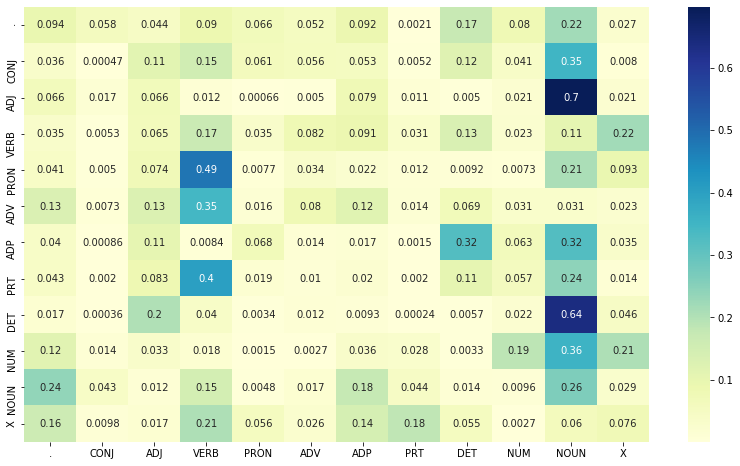

In [23]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True,cmap="YlGnBu")
# sns.color_palette("Paired")
plt.show()

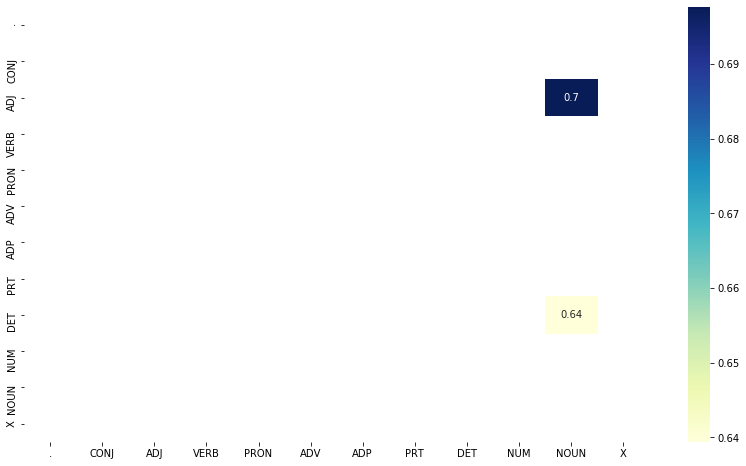

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True,cmap="YlGnBu")
plt.show()

<b>Viterbi Algorithm</b>

The steps are as follows:

1. Given a sequence of words.
2. iterate through the sequence
3. for each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. assign the tag which has maximum probability obtained in step 3 above.
5. move to the next word in sequence to repeat steps 3 and 4 above.

In [25]:
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Testing Vanilla Viterbi Algorithm 

In [46]:

random.seed(999)

# choosing  random 5 sents
rndom_test_subset = [random.randint(1, len(validation_data)) for x in range(5)]

# list of sents
test_run = [validation_data[i] for i in rndom_test_subset]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]


In [27]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check)/len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Time taken in seconds:  25.951589345932007
Vanilla Viterbi Algorithm Accuracy:  93.7062937062937


## 4. Observing Unknown Words

In [28]:
#Checking for incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

print("Total Words tagged incorrectly :", len(incorrect_tagged_words))
print("\n")
print("And those words are :", incorrect_tagged_words)

Total Words tagged incorrectly : 9


And those words are : [(('inaccurately', '.'), ('inaccurately', 'ADV')), (('net', 'ADJ'), ('net', 'NOUN')), (('acknowledge', '.'), ('acknowledge', 'VERB')), (('infusion', '.'), ('infusion', 'NOUN')), (('forecast', 'VERB'), ('forecast', 'NOUN')), (('Reasons', '.'), ('Reasons', 'NOUN')), (('walkout', '.'), ('walkout', 'NOUN')), (('procedural', '.'), ('procedural', 'ADJ')), (('strike', 'NOUN'), ('strike', 'VERB'))]


<b>Note:</b>

The loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag

Hence, let's see the words which are present in the the test or validation set but not in training data. Based on those observations, we can define <u>generalized</u> rules to predict the POS tags for them

In [29]:
# Unknown words: words not present in our training dataa
test_vocabulary_set = set([t for t in validation_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 355


Unknown Words : ['Colorado', 'Walkman', 'sticker-shock', 'novelist', 'deliberating', '250,000', 'apologize', '1990-91', 'comprehensive', 'unfettered', 'Mich.-based', 'readings', '*-133', 'Chardonnay', 'Ballantine\\/Del', 'portrayal', 'characterizing', 'drooled', 'depository', 'experiencing', 'transporting', 'pretext', 'Joanne', 'bars', 'Roosevelt', 'Handelsbanken', 'breathtaking', 'depression', 'meals', 'exempt', '415', 'cyclical', 'frustrating', 'excited', 'Fortune', 'enabled', 'A-D', 'speculator', 'talked', 'lotions', 'Atsushi', 'accidentally', '51.6', 'Pitcher', 'loose', 'shaded', 'Possible', 'four-foot-high', 'Rouge', 'Hurley', 'Chuck', 'Karl', 'procedural', 'fits', 'sky', 'slippery', 'passions', 'complexes', 'Reasons', 'La.', 'Scandinavian', 'bellwether', '*T*-216', 'composed', 'recyclability', 'hits', 'FAX', 'Monchecourt', 'Coche-Dury', 'Cross', 'Virtually', 'Rae', 'simulates', 'APPEARS', '4.5', 'Can', 'Interviews', 'government-certified', 'moneymakers

### 4.1 Techniques to handle Unknown words

### Unigram tagger

In [30]:
# Lexicon (or unigram tagger)

unigram_tagger = nltk.UnigramTagger(train_data)
accuracy_unigram_tagger = unigram_tagger.evaluate(validation_data)
print("The accuracy of the Unigram Tagger is: ", accuracy_unigram_tagger)# Lexicon (or unigram tagger)


The accuracy of the Unigram Tagger is:  0.9051641389902092


In [31]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

In [32]:
sorted(tag_prob, key=lambda x: x[1])

[('CONJ', 0.022363748729927618),
 ('PRON', 0.02725549142635675),
 ('ADV', 0.0315920684634481),
 ('PRT', 0.032073910356458256),
 ('NUM', 0.035300156074874044),
 ('ADJ', 0.06343553269716237),
 ('X', 0.06599138969486838),
 ('DET', 0.08700388615961537),
 ('ADP', 0.09770915604344957),
 ('.', 0.11589345009270219),
 ('VERB', 0.1351671258131082),
 ('NOUN', 0.28621408444802915)]

<b>Note: </b>
    As can be seen, <b>Noun is the most probable tag</b> from our training data. Hence using it as the deafultin the rule based approach

### Unigram + Rule Based

In [47]:

patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN') # Default
    ]

In [48]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [49]:
# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_data, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(validation_data)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.959301209445191


### Bigram Tagger

In [50]:

bigram_tagger = nltk.BigramTagger(train_data, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(validation_data)
accuracy_bigram_tagger = bigram_tagger.evaluate(validation_data)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -",accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 0.9614129391437896


### Trigram tagger

In [51]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff = bigram_tagger)
trigram_tagger.evaluate(validation_data)
accuracy_trigram_tagger = trigram_tagger.evaluate(validation_data)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9610289882894989


<b>Note: </b>

As we can see best accuracy is achieved from bigram and trigram tagger

## 5. Viterbi Modification-Technique I

In this modification,
 - transition probability of tags when emission probability is zero in case of unknown words 
 - Adding Tag occurance probability weights from training data

In [52]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [53]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',accuracy*100)

Time taken in seconds:  20.97590708732605
Vanilla Viterbi for Unknown Words Accuracy:  95.8041958041958


In [54]:
# Adding Tag occurance probability weights: we will apply weights based on the probability of tag occurance 
# to the transition probabilities of tags and then use the resulting probability for predicting unknown words
# POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('.', 0.11589345009270219),
 ('CONJ', 0.022363748729927618),
 ('ADJ', 0.06343553269716237),
 ('VERB', 0.1351671258131082),
 ('PRON', 0.02725549142635675),
 ('ADV', 0.0315920684634481),
 ('ADP', 0.09770915604344957),
 ('PRT', 0.032073910356458256),
 ('DET', 0.08700388615961537),
 ('NUM', 0.035300156074874044),
 ('NOUN', 0.28621408444802915),
 ('X', 0.06599138969486838)]

In [55]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Weighted_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [56]:
# tagging the test sentences
start = time.time()
tagged_seq = Weighted_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified = len(viterbi_word_check)/len(tagged_seq) * 100
print('Modified Vanilla Viterbi for Unknown Words Accuracy: ', accuracy_viterbi_modified)

Time taken in seconds:  20.754494190216064
Modified Vanilla Viterbi for Unknown Words Accuracy:  95.1048951048951


Thus, we see that we have got a much better accuracy by using weighted transition probabilties.

## 6. Viterbi Modification-Technique II

In this modification, 
- based on previous analysis in section 4, using  Bigram Tagger backed off by unigram and rule based tagger 

In [57]:
## Based on the unknown words in section 4, defining general rules
def bigram_tagger(word, train_set = train_data):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN') # Default
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [58]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_bigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in training_vocabulary_set:
            unk_word_tag=bigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [62]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_bigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_bigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_bigram_accuracy = len(viterbi_bigram_word_check)/len(tagged_seq) * 100
print('Modified Viterbi Bigram Tagger Accuracy: ', viterbi_bigram_accuracy)

Time taken in seconds:  26.906004190444946
Modified Viterbi Bigram Tagger Accuracy:  95.8041958041958


## 7. Comparing the tagging accuracies 

In [61]:
acccuracy_for_ngram = [
                                   ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                 ]
ngram_accuracy_df = pd.DataFrame(acccuracy_for_ngram, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

ngram_accuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

ngram_accuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Unigram Tagger,90.516414
Unigram + RegexpTagger,95.930121
Bigram Tagger + Unigram_tagger,96.141294
Trigram Tagger + Bigram_tagger,96.102899


As can be seen Bigram backed by unigram has the highest accuracy, hence using this in our second modification of viterbi

In [75]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Viterbi Modified (handling emission probability coming zero and probability of Tags accounted)', accuracy_viterbi_modified], 
                  ['Viterbi + bigram_tagger', viterbi_bigram_accuracy]]


acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df


,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,93.706294
Viterbi Modified (handling emission probability coming zero and probability of Tags accounted),95.104895
Viterbi + bigram_tagger,95.804196


<b>Conclusion:</b> Modification Technique-2 (Viterbi + bigram tagger ) gives the highest accuracy

## 8. Corrections by Modification

List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [65]:
from nltk.tokenize import word_tokenize

In [66]:
file = open("Test_sentences.txt", "r")
print(file.read())

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






### Testing

#### Test case -1 

In [67]:
sentence_test_1 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test_1)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('NASA', '.'), ('invited', '.'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', '.'), ('Satellite', '.'), ('.', '.')]


In [68]:
tagged_seq_modified = Viterbi_bigram_Tagger(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


##### Result: 
1. 'NASA', ''ICESAT-2','Satellite' were incorrectly labelled as '.' with vanilla viterbi whereas the modified viterbi  identified them as nouns, which is the correct tag when seen intuitively


#### Test case -2

In [69]:
sentence_test_2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test_2)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')]


In [70]:
tagged_seq_modified = Viterbi_bigram_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


##### Result: 
1. 'Android', 'OS' were incorrectly labelled as '.' with vanilla viterbi whereas the modified viterbi  identified them as nouns, which is the correct tag when seen intuitively
2. '2011','2013' was marked as '.' with vanilla viterbi whereas the modified viterbi tagged it correctly as a number


#### Test case -3

In [71]:
sentence_test_3='Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test_3)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.')]


In [72]:
tagged_seq_modified = Viterbi_bigram_Tagger(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


##### Result: 
1. 'Google', 'Twitter', 'firehose' were incorrectly labelled as '.' with vanilla viterbi whereas the modified viterbi  identified them as nouns, which is the correct tag when seen intuitively
2. '2015' was marked as '.' with vanilla viterbi whereas the modified viterbi tagged it correctly as a number

#### Test case -4

In [73]:
sentence_test_4='I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'
words = word_tokenize(sentence_test_4)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('I', 'PRON'), ('Instagrammed', '.'), ('a', 'DET'), ('Facebook', '.'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', '.'), ('smartphone', '.'), ('and', 'CONJ'), ('uploaded', '.'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', '.'), ('.', '.')]


In [74]:
tagged_seq_modified = Viterbi_bigram_Tagger(words)
print(tagged_seq_modified)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'NOUN'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'NOUN'), ('.', '.')]


##### Result: 
1. 'Instagrammed','uploaded' were incorrectly labelled as '.' with vanilla viterbi whereas the modified viterbi identified them as verb, which is the correct tag when seen intuitively
2. 'Facebook', 'post','smartphone','Youtube' were incorrectly labelled as '.' with vanilla viterbi whereas the modified viterbi  identified them as nouns, which is the correct tag when seen intuitively


---
                                                 End Of Assignment

---